In [9]:
import numpy as np
import pandas as pd

data = pd.read_excel('EPOC dataset.xlsx')

columns = ['metal','support','wt.%','ionic species','particle size(nm)','metal loading (mg)','CO2:H2 ratio','temp(℃)','rCO(mol/s)',
          'voltage(V)','ρCO','ΛCO']
data = data[columns]

# change string in data['metal'] into int with metal's atomic mass
data['metal'] = data['metal'].replace(['Fe','Co','Ni','Cu','ZnO','Ru','Rh','Pd','Pt'],
                                      ['55.8','58.9','58.7','63.5','65.4','101.1','102.9','106.4','195.1']).astype(float)

# change the string in data['support'] into int, where 0: no support; 1: Co3O4; 2: ZnO; 3: YSZ; 4: α-Al2O3; 5: CNF
data['support'] = data['support'].fillna(0)
data['support'] = data['support'].replace(['Co3O4','ZnO','YSZ','α-Al2O3','CNF'],['1','2','3','4','5']).astype(int)

# change string in data['wt.%'] into int, where 100: no support
data['wt.%'] = data['wt.%'].fillna(100).astype(float)

# change string in data['ionic species'] into int, where -2:O2-; 1:H+; 2:Li+, 3:Na+; 4:K+
data['ionic species'] = data['ionic species'].replace(['O2-','H+','Li+','Na+','K+'],['-2','1','2','3','4']).astype(int)

# change string in data['CO2:H2 ratio'] into int by calculating the ratios
data['gas ratio'] = data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))

# delete the data['CO2:H ratio'] column, which has been converted into data['gas ratio']
data = data.drop('CO2:H2 ratio', axis=1)

# change the columns' names into abbreviations, where M:metal, S:support, WT.%:wt.%, IS:ionic species, PS:particle size,
# ML:metal loading, T: temperature, RR:reaction rate, V:applied potential, ρ:enhancement ratio, Λ:Faradaic efficiency, GR:gas ratio
data.columns = ['M','S','WT.%','IS','PS','ML','T','RR','V','ρ','Λ','GR']

# define a function to determine which direction the IS migrates. Value of 1 means IS moves to catalyst, 0 means IS removes from catalyst
def ionic_dir(row):
    if row['IS'] * row['V'] < 0:
        return 1
    else:
        return 0
# create a new column named 'MD' (migration direction)
data['MD'] = data.apply(ionic_dir, axis=1)

# define a function to make a classification for EPOC behavior based on the applied potential and ρ values
# 0: electrophobic, 1: electrophilic
def electro_class(row):
    if row['V'] > 0 and row['ρ'] >= 1:
        return 0
    elif row['V'] < 0 and row['ρ'] >= 1:
        return 1
    elif row['V'] > 0 and row['ρ'] <= 1:
        return 1
    elif row['V'] < 0 and row['ρ'] <= 1:
        return 0
    else:
        return 'undefined'

# create a new column named 'BH' (EPOC behavior)
data['BH'] = data.apply(electro_class, axis=1)

# determine the columns that are used as features
features = ['M','S','IS','T','GR','V','MD']

X = data[features]
y = data['ρ']

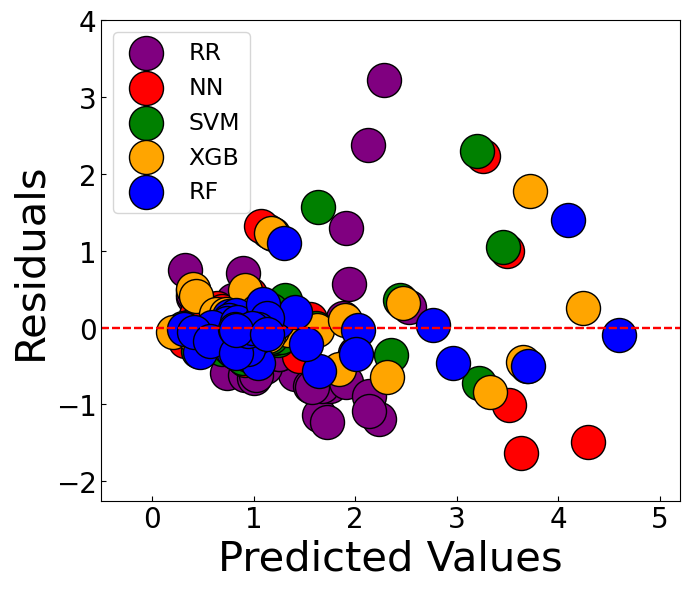

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

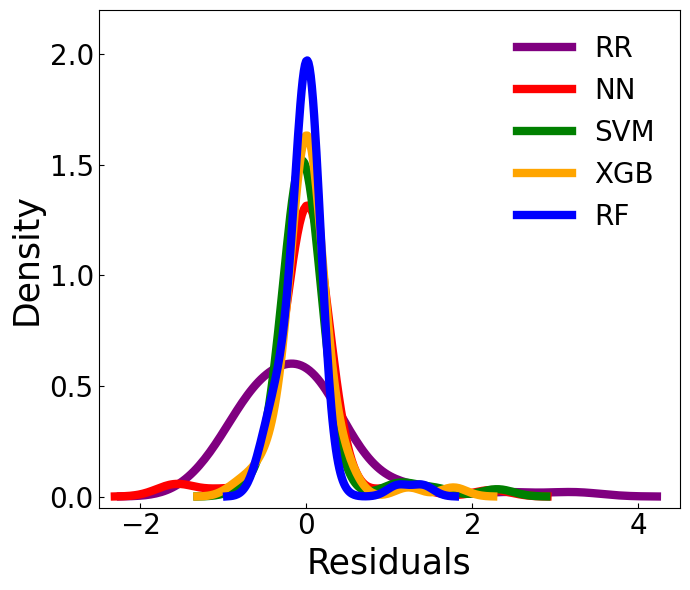

In [21]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

RFR = RandomForestRegressor(n_estimators=5, max_depth=8, min_samples_split=2, random_state=0)
XGBR = XGBRegressor(n_estimators=30, max_depth=5, eta=0.3, subsample=0.5, colsample_bytree=0.5, random_state=0)
NN = MLPRegressor(hidden_layer_sizes=(20,) * 5, max_iter=1000, activation='relu', solver='adam', random_state=0)
RR = Ridge(alpha=1, random_state=0)
svr = SVR(kernel='rbf', C=1, gamma=1)

RFR.fit(X_train, y_train)
XGBR.fit(X_train, y_train)
svr.fit(X_train, y_train)
NN.fit(X_train, y_train)
RR.fit(X_train, y_train)

models = {
    'RR': RR,
    'NN': NN,
    'SVM': svr,
    'XGB': XGBR,
    'RF': RFR
}
colors = ['purple', 'red', 'green', 'orange', 'blue']

# residual plots
plt.figure(figsize=(7, 6))
for (model_name, model), color in zip(models.items(), colors):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, label=model_name, s=600, color=color, edgecolors='black')
    plt.axhline(0, color='red', linestyle='--')

plt.xlabel('Predicted Values', size=30)
plt.ylabel('Residuals', size=30)
plt.tick_params(axis='x', labelsize=20, direction='in')
plt.tick_params(axis='y', labelsize=20, direction='in')
plt.xlim([-0.5, 5.2])
plt.ylim([-2.25, 4])
plt.legend(loc=2, fontsize=17)
plt.tight_layout()
plt.savefig('Residual Plots Across Models.jpg', format='jpeg', dpi=600)
plt.show()

# density vs. residuals
plt.figure(figsize=(7, 6))
for (model_name, model), color in zip(models.items(), colors):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    sns.kdeplot(residuals, color=color, lw=6, label=model_name)
plt.xlabel('Residuals', size=25)
plt.ylabel('Density', size=25)
plt.tick_params(axis='x', labelsize=20, direction='in')
plt.tick_params(axis='y', labelsize=20, direction='in')
plt.xlim([-2.5, 4.5])
plt.ylim([-0.05, 2.2])
plt.legend(loc=1, frameon=False, fontsize=20)
plt.tight_layout()
plt.savefig('Residuals Distribution Across Models.jpg', format='jpeg', dpi=600)
plt.show()